# Set-Up

## Import

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import altair_saver
import selenium
import pycountry
import geopandas
import countrynames
import warnings
from geopy.geocoders import Nominatim

## Configure

In [2]:
warnings.filterwarnings('ignore')

## Fetch data

In [3]:
initial_data_url = "https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6"
final_data_url = "https://data.mendeley.com/datasets/kg72dst75p/1"

In [4]:
data_1day = pd.read_csv("../data/Coronavirus_Data_Cases_1a. Per day.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_1date = pd.read_csv("../data/Coronavirus_Data_Cases_1b. Per date.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_2day = pd.read_csv("../data/Coronavirus_Data_Cases_2a. Per day_population.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_2date = pd.read_csv("../data/Coronavirus_Data_Cases_2b. Per date_population.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_5day = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per day_popul_surf.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_5date = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per date_popul_surf.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')

## Cleaning Data
### Adjust Data types and columns

In [5]:
def clean_util(dataframe, name, statistics=False):
    if statistics:
        dataframe_with_metric = dataframe.iloc[-4:].copy()
        dataframe = dataframe.iloc[:-5].copy()
    else:
        dataframe_with_metric = dataframe.iloc[0].T.squeeze()
        dataframe = dataframe.iloc[1:].copy()
    dataframe.index.name = name
    if name == 'Date':
        dataframe.index = pd.to_datetime(dataframe.index, format='%d/%m/%Y')
    else:
        dataframe.index = dataframe.index.astype(int)
    return (dataframe, dataframe_with_metric)

def clean_up(dataframe):

    dataframe.dropna(axis=1, how='all', inplace=True)
    dataframe = dataframe.apply(pd.to_numeric, args={'coerce'})
    dataframe.columns = [col.replace('United Kingdom', 'UK') for col in dataframe.columns]

    if type(dataframe.index[0]) != str:
        dataframe.index.name = 'Day'
        return dataframe

    elif 'Density' in dataframe.index[0]  or 'Population' in dataframe.index[0]:
        temp = dataframe.index[1]
        if '/' not in dataframe.index[1]: 
            return clean_util(dataframe, 'Day')
        elif '/' in dataframe.index[1]:
            return clean_util(dataframe, 'Date')
    
    else:
        return clean_util(dataframe, 'Date', statistics=True)


data_1day = clean_up(data_1day)
data_1date, data_1date_metrics = clean_up(data_1date)
data_2day, data_2day_population = clean_up(data_2day)
data_2date, data_2date_population = clean_up(data_2date)
data_5day, data_5day_density = clean_up(data_5day)
data_5date, data_5date_density = clean_up(data_5date)

### Choose relevant columns - truncating data

In [6]:
def truncate_date(data_date):
    last_day = data_date.loc['04/04/2020']
    last_day = last_day.sort_values(ascending=False)
    last_day_high = last_day[:30]
    last_day_low = last_day[-30:]
    data_high = data_date[last_day_high.index]
    data_low = data_date[last_day_low.index]
    return data_high, data_low

def truncate_day(data_day):
    columns = data_day.columns
    data_status = data_day[columns] > 0
    all_days = data_status.all(axis=0)
    countries_complete = columns[all_days]
    countries_uncomplete = columns[~all_days]
    days_recorded = data_status[countries_uncomplete].apply(pd.Series.idxmin)
    days_recorded.sort_values(ascending=False, inplace=True)
    days_recorded_high = days_recorded[:30 - len(countries_complete)]
    days_recorded_low = days_recorded[-30:]
    data_high = data_day[countries_complete | days_recorded_high.index]
    data_low = data_day[days_recorded_low.index]
    return data_high, data_low

data_1date_trunc, data_1date_low = truncate_date(data_1date) 
data_2date_trunc, data_2date_low = truncate_date(data_2date)
data_5date_trunc, data_5date_low = truncate_date(data_5date)
data_1day_trunc, data_1day_low = truncate_day(data_1day)   
data_2day_trunc, data_2day_low = truncate_day(data_2day)
data_5day_trunc, data_5day_low = truncate_day(data_5day)

# 4-step algorithm

- **Step 1:** Keep or disregard terms of the time series in the flattening regime if such regime exists 
- **Step 2:** Calculate all the rates of change for every pair xj{ti}, xj{ti+1}, and find number of day kj when for the first time rate appears to be larger than 20% of the mean value of previous initial rates (that are always small in our time series).
- **Step 3:** For all time series xj{ti} keep terms from i=k...m where k minimum of all kj.
- **Step 4:** Run the agglomerative clustering algorithm with single/complete linkage and Eu-
clidean distance.

## Step 1: Flattening Regime calculation

In [7]:
def new_cases(data):
    df_new_cases = data.diff()
    df_new_cases.iloc[0] = data.iloc[0]
    return df_new_cases 

In [8]:
new_cases_1date = new_cases(data_1date)
new_cases_2date = new_cases(data_2date)
new_cases_5date = new_cases(data_5date)

new_cases_1day = new_cases(data_1day)
new_cases_2day = new_cases(data_2day)
new_cases_5day = new_cases(data_5day)

### Criteria for flattening: Less cases than the days before
Averaged approximation is used to account for outliers and make the flattening calculation more robust  

In [9]:
width_win = 10

mid = width_win // 2

def cut_flattening(data):
    data = new_cases(data)
    flattening_detector = lambda df: df.iloc[:mid].mean() > df.iloc[mid:].mean() 
    temp = data.rolling(window=10, center=True).apply(flattening_detector)
    data[temp == True] = pd.NA
    return data

In [10]:
cutted_1date = cut_flattening(data_1date)
cutted_2date = cut_flattening(data_2date)
cutted_5date = cut_flattening(data_5date)

cutted_1day = cut_flattening(data_1day)
cutted_2day = cut_flattening(data_2day)
cutted_5day = cut_flattening(data_5day)

## Step 2 + 3: Find starting day

In [11]:
inital_days = 7

def step2_3(data, initial_days=inital_days, expanding=True):    
    rates = pd.DataFrame(np.gradient(data, axis=0), index=data.index, columns=data.columns)
    if expanding:
        initial_rates = rates.expanding().mean()
    else:
        initial_rates = pd.DataFrame(0, index=rates.index, columns=rates.columns)
        initial_rates += rates.iloc[:initial_days].mean()
    temp_mask = initial_rates[initial_days:] * 0.2 < rates[initial_days:] 
    min_k_mask = temp_mask.any(axis=1) 
    min_k = min_k_mask.idxmax()
    return min_k 

expd = False
min_k_1date = step2_3(data_1date_trunc, expanding=expd)
min_k_2date = step2_3(data_2date_trunc, expanding=expd)
min_k_5date = step2_3(data_5date_trunc, expanding=expd)
min_k_1day = step2_3(data_1day_trunc, expanding=expd)
min_k_1day = step2_3(data_2day_trunc, expanding=expd)
min_k_1day = step2_3(data_5day_trunc, expanding=expd)

# Visualizations

## Gradients of 8 selected countries

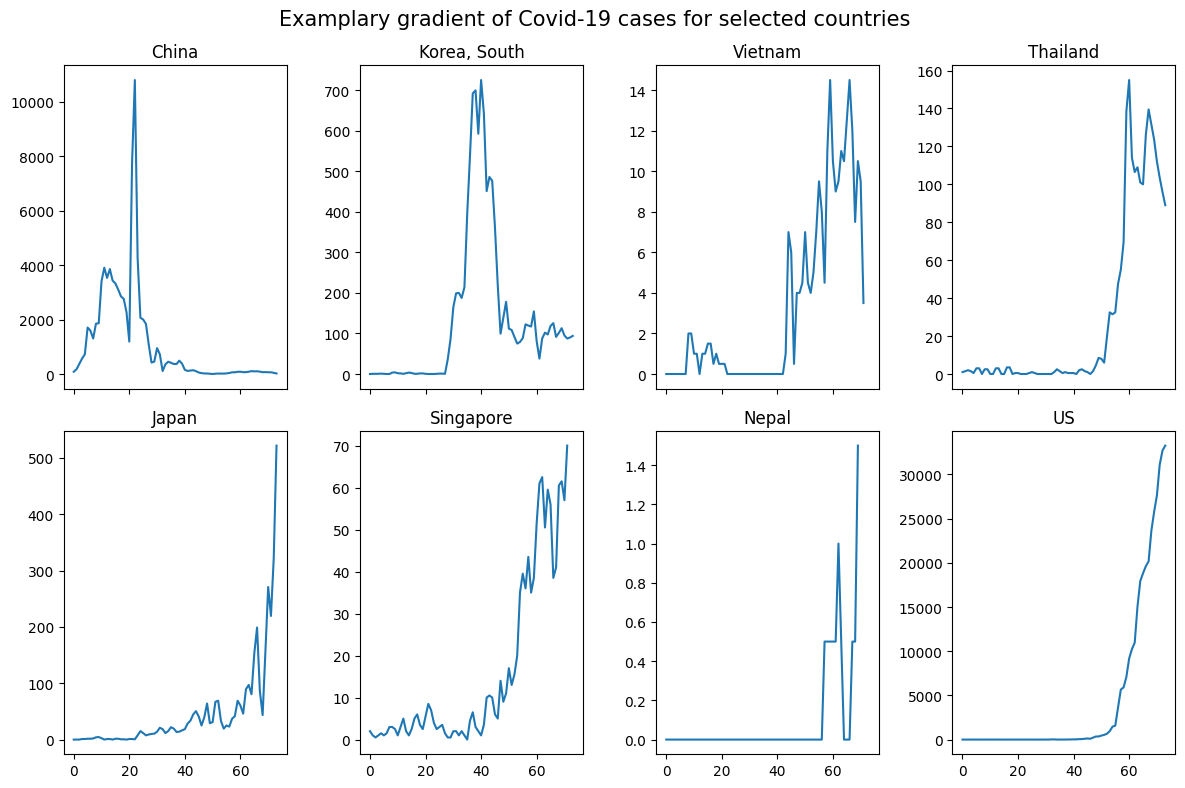

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8), sharex=True)

selected_countries = data_1day[['China', 'Korea, South', 'Vietnam', 'Thailand', 'Japan', 'Singapore', 'Nepal', 'US']]
for i, country in enumerate(selected_countries.columns):
    ax = axes.flat[i]
    ax.plot(np.gradient(data_1day[country]))
    ax.set_title(country)

fig.suptitle('Examplary gradient of Covid-19 cases for selected countries', fontsize=15)
fig.tight_layout()

fig.savefig('../figures/Examplary_gradient.png')

## Cases

### Absolute cases

#### Highest and oldest cases

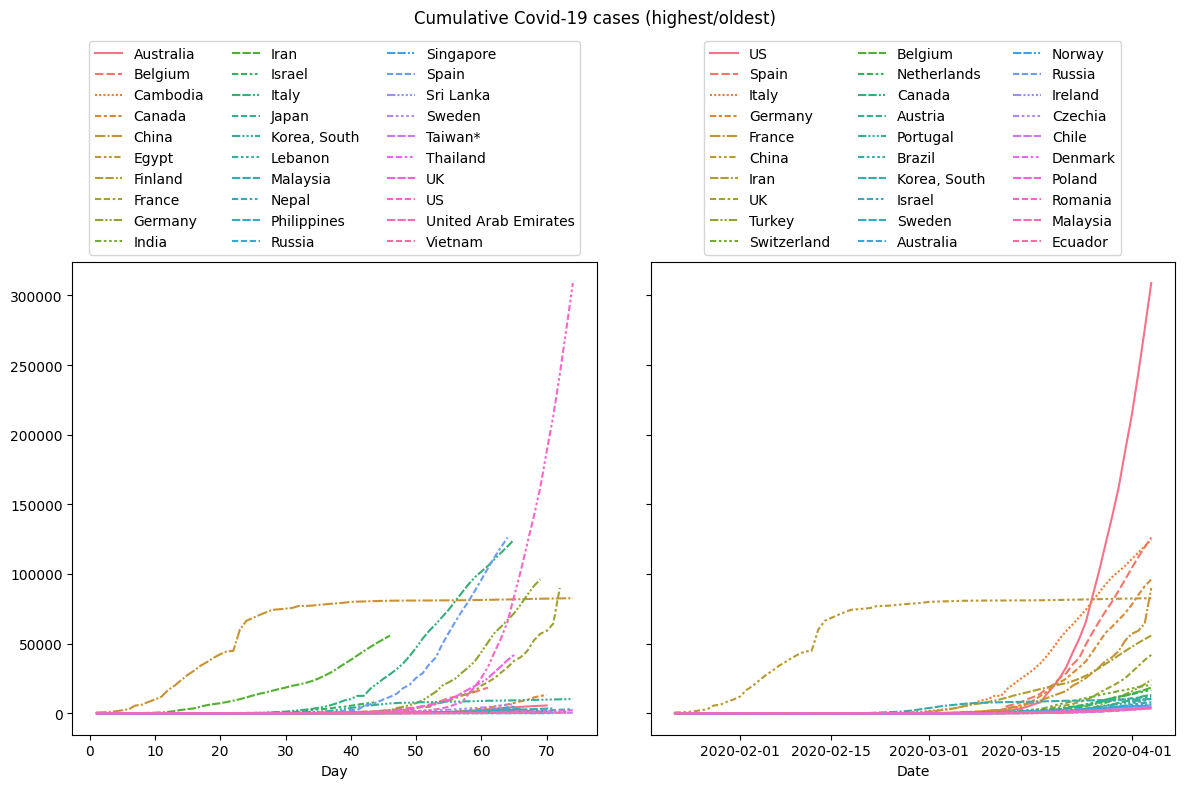

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

sns.lineplot(data=data_1day_trunc, ax=ax1)
sns.lineplot(data=data_1date_trunc, ax=ax2)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

fig.suptitle('Cumulative Covid-19 cases (highest/oldest)')
fig.tight_layout()

fig.savefig('../figures/Fig1_high.png')

#### Lowest and latest cases

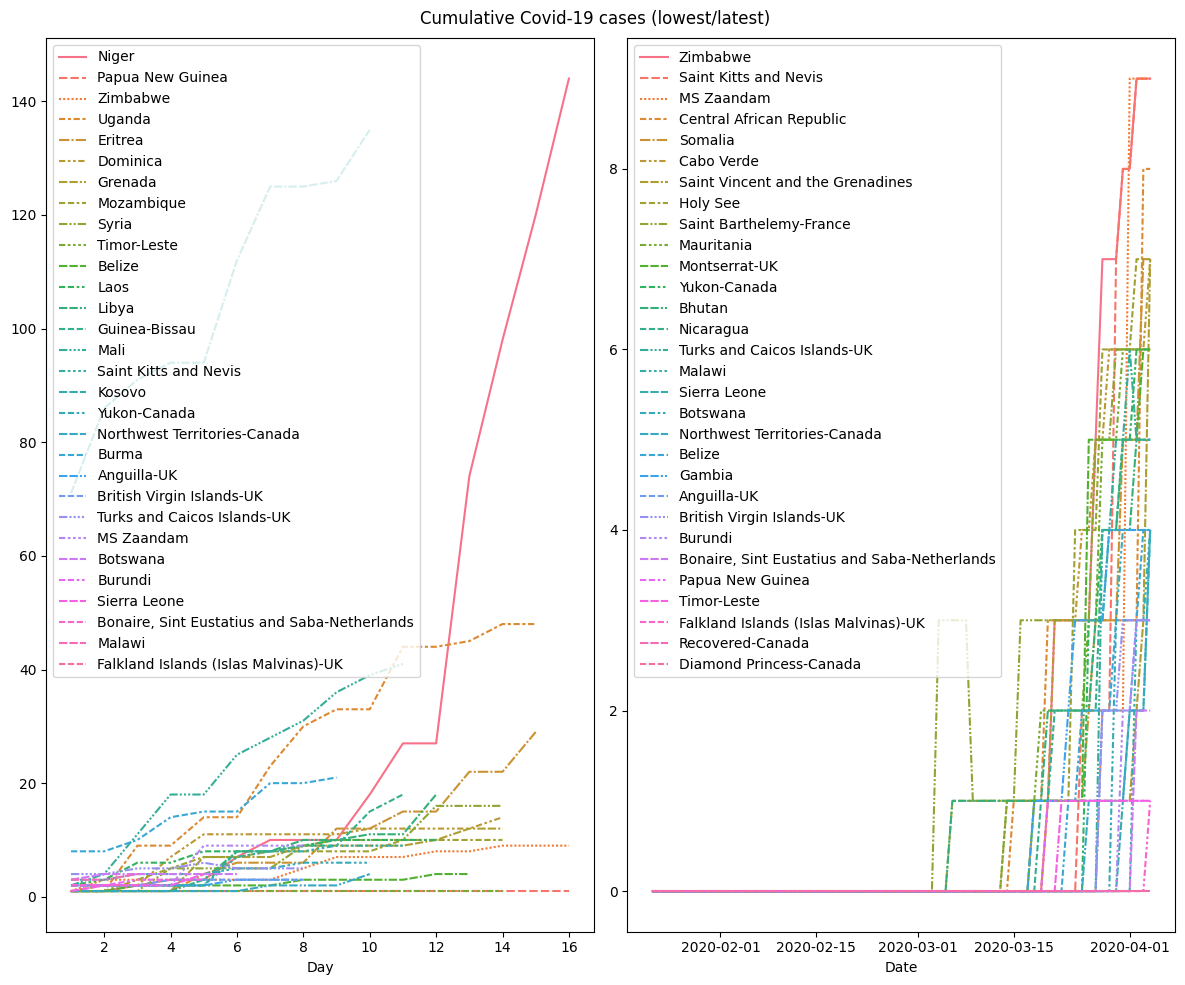

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

sns.lineplot(data=data_1day_low, ax=ax1)
sns.lineplot(data=data_1date_low, ax=ax2)

fig.suptitle('Cumulative Covid-19 cases (lowest/latest)')
fig.tight_layout()

fig.savefig('../figures/Fig1_low.png')

### Cases per 1 million

#### Highest and oldest cases

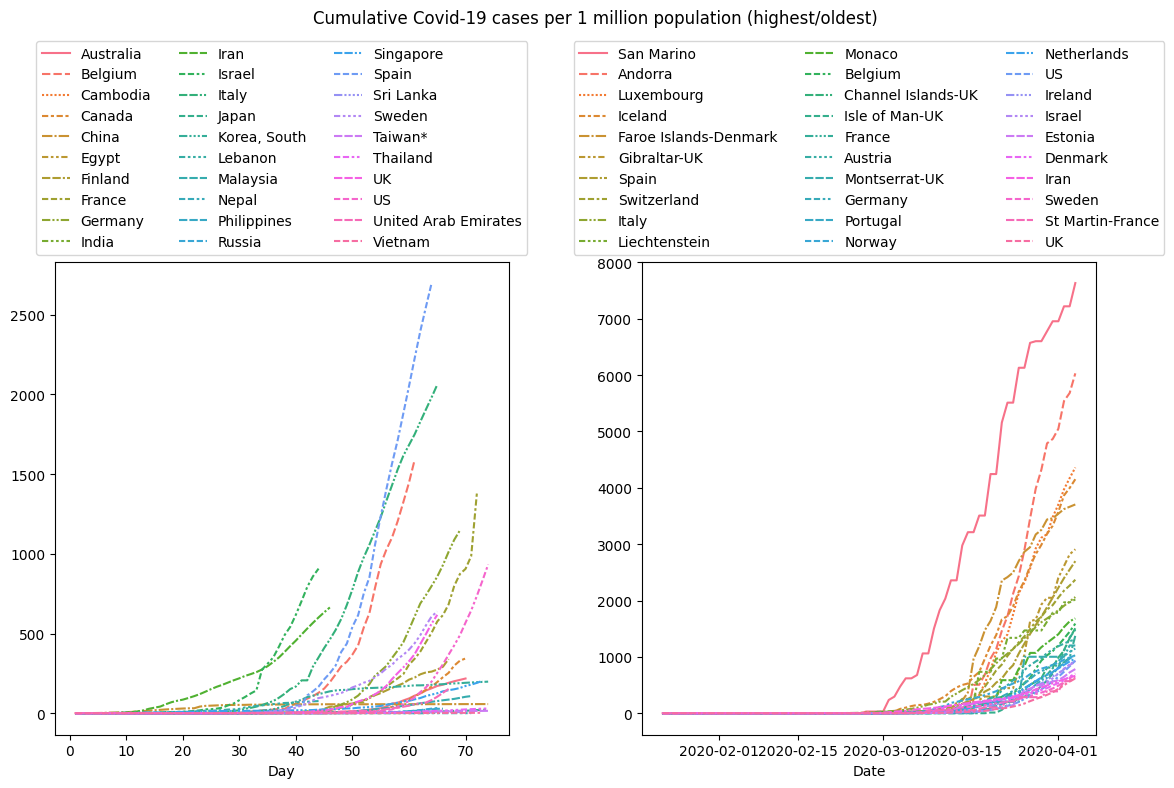

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

sns.lineplot(data=data_2day_trunc, ax=ax1)
sns.lineplot(data=data_2date_trunc, ax=ax2)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

fig.suptitle('Cumulative Covid-19 cases per 1 million population (highest/oldest)')
fig.tight_layout()

fig.savefig('../figures/Fig2_high.png')

#### Lowest and latest cases

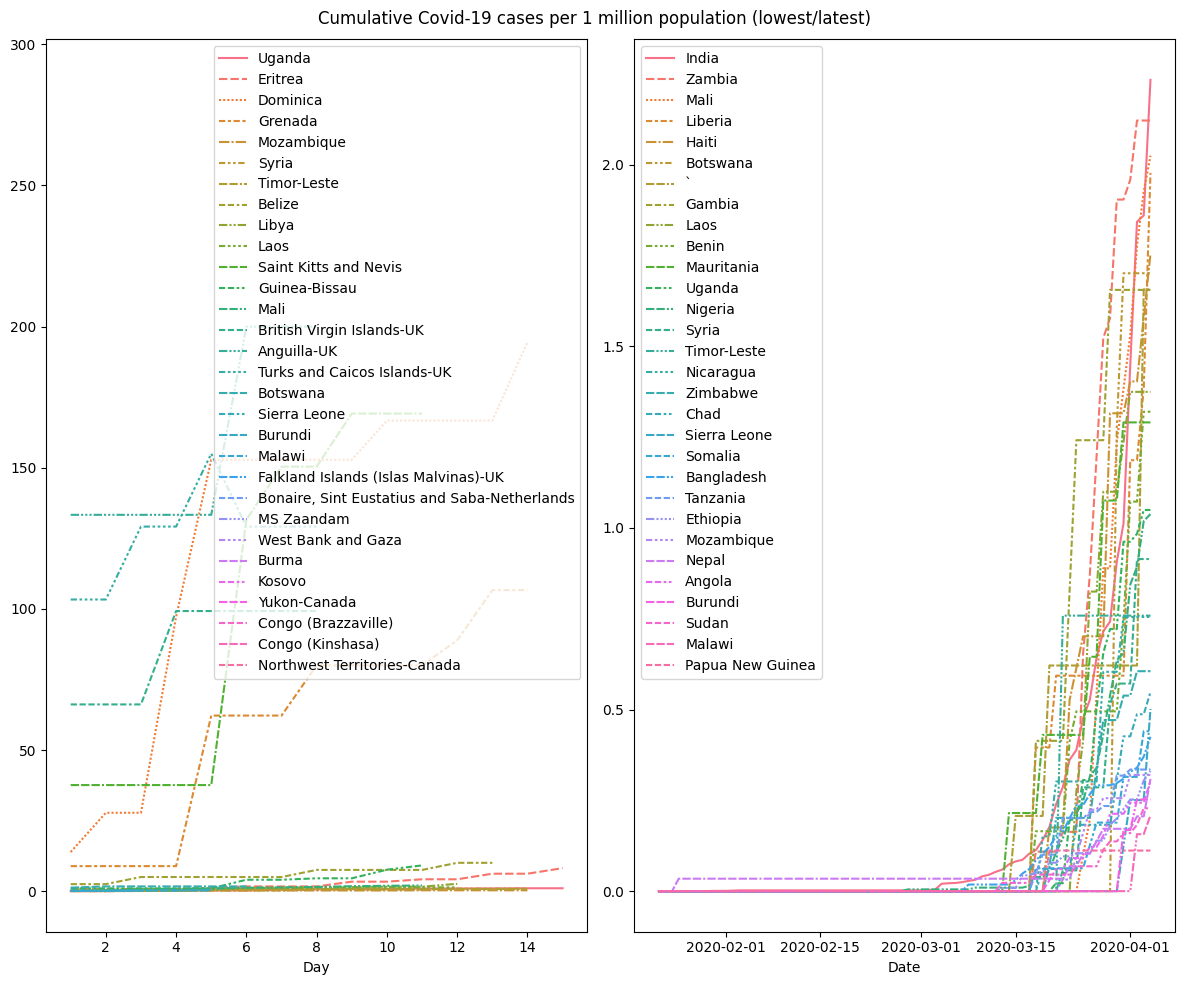

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

sns.lineplot(data=data_2day_low, ax=ax1)
sns.lineplot(data=data_2date_low, ax=ax2)

fig.suptitle('Cumulative Covid-19 cases per 1 million population (lowest/latest)')
fig.tight_layout()

fig.savefig('../figures/Fig2_low.png')

### Cases per population per land

#### Highest and oldest cases

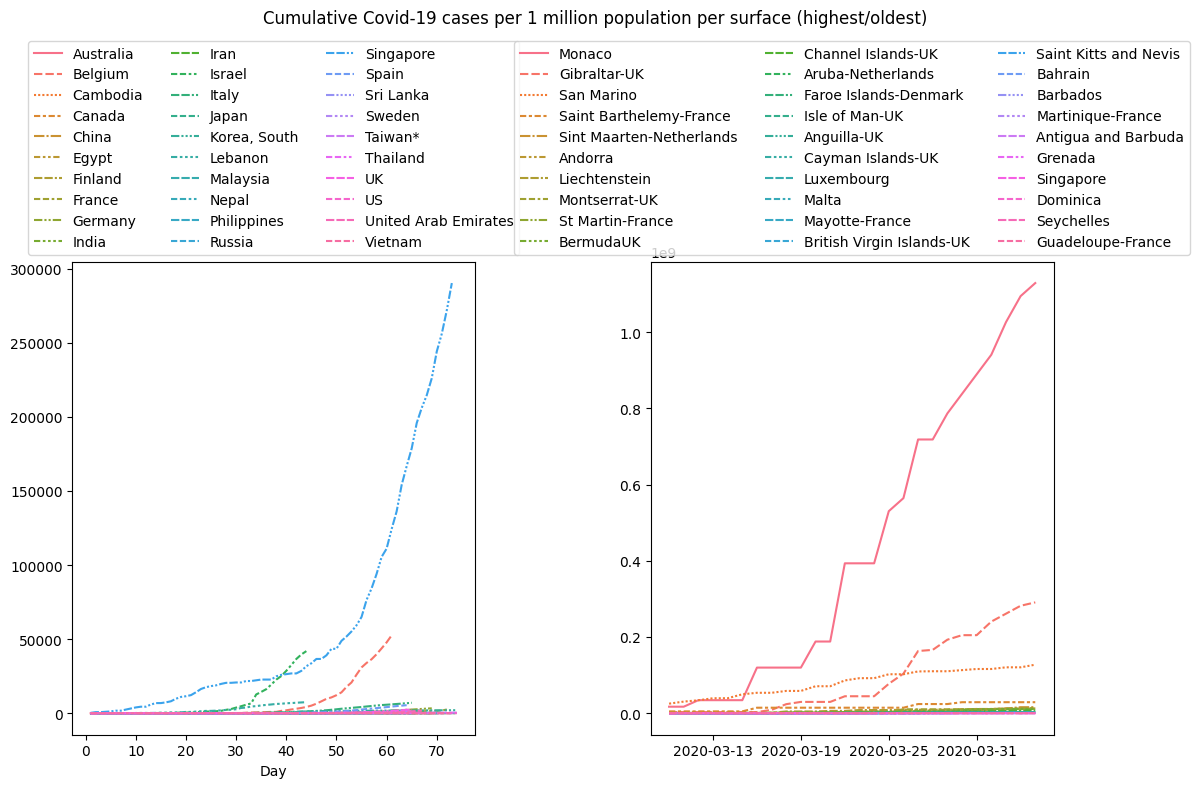

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

sns.lineplot(data=data_5day_trunc, ax=ax1)
sns.lineplot(data=data_5date_trunc.loc[pd.date_range('2020-03-10', '2020-04-04')], ax=ax2)

ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

fig.suptitle('Cumulative Covid-19 cases per 1 million population per surface (highest/oldest)')
fig.tight_layout()

fig.savefig('../figures/Fig5_high.png')

#### Lowest and latest cases

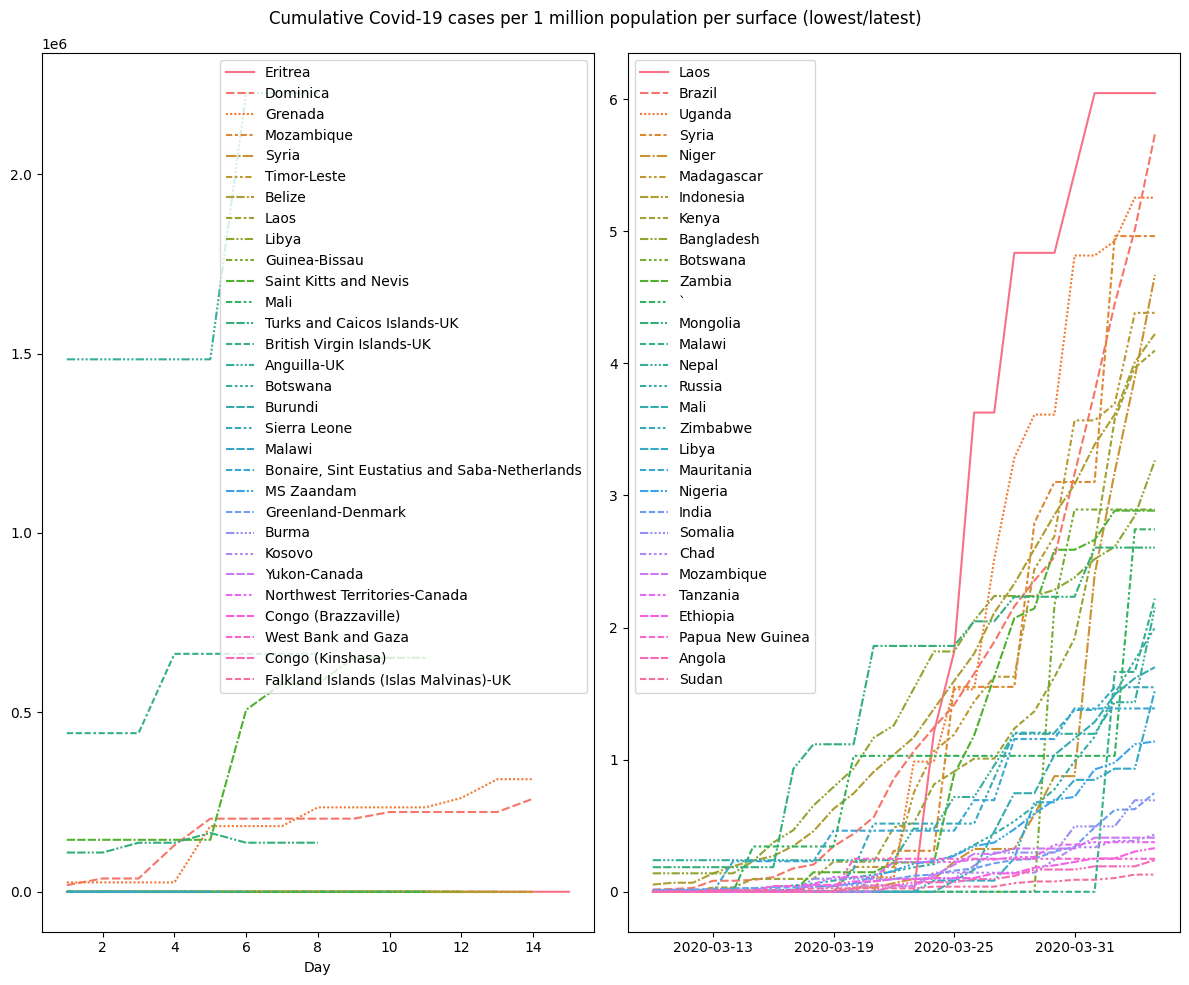

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

sns.lineplot(data=data_5day_low, ax=ax1)
sns.lineplot(data=data_5date_low.loc[pd.date_range('2020-03-10', '2020-04-04')], ax=ax2)

ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

fig.suptitle('Cumulative Covid-19 cases per 1 million population per surface (lowest/latest)')
fig.tight_layout()

fig.savefig('../figures/Fig5_low.png')

## Agglomerative Clustering

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

In [20]:
def plot_hierarchy(data, ax, complete=False):
    data = data.T
    if not complete:
        linkage_matrix = linkage(data, method='single', metric='euclidean')
    else:
        linkage_matrix = linkage(data, method='complete', metric='euclidean')
    
    country_names = data.index.to_list()

    def llf(i):
        return '{}---{}'.format(country_names[i], i)

    R = dendrogram(
        linkage_matrix
        , ax=ax
        , orientation='right'
        , leaf_label_func=llf
        , count_sort=True
    )
    ax.set_xticks([])
    return R, pd.DataFrame(linkage_matrix, columns=['cluster1', 'cluster2', 'distance', 'members'])

### Clustering absolute cases of day data

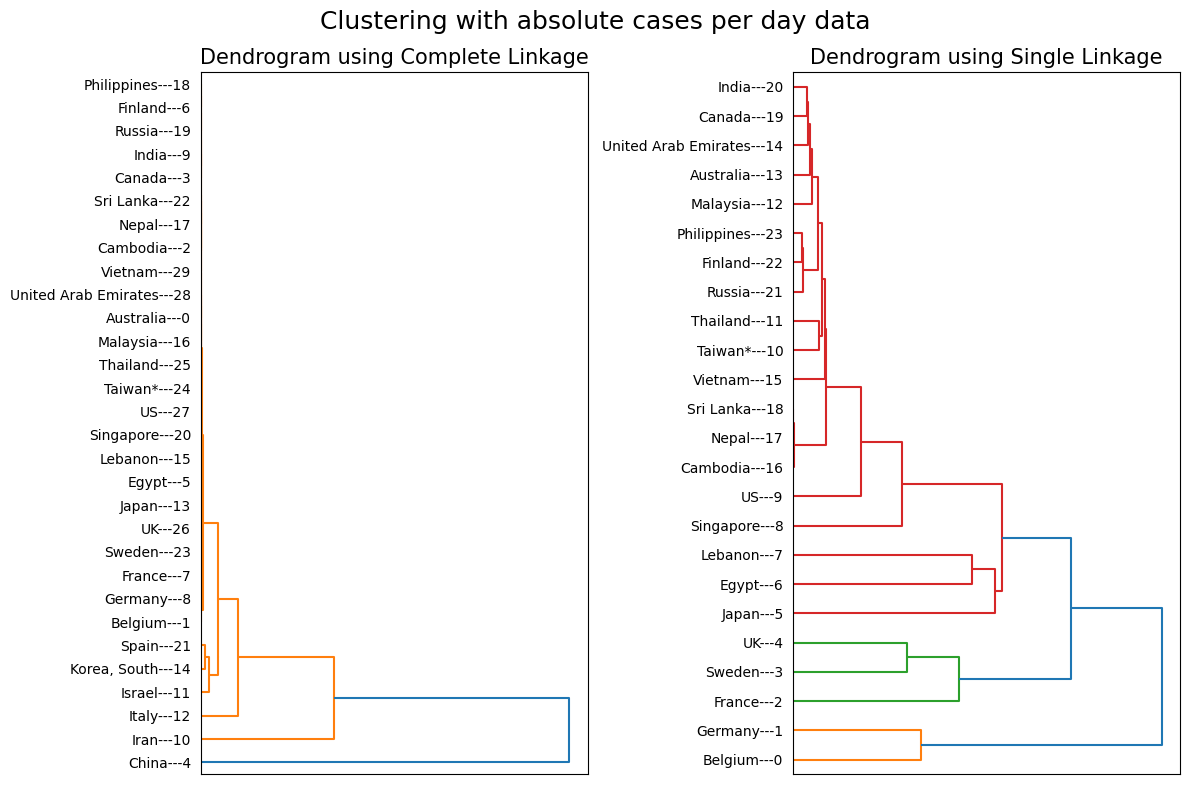

In [21]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2)

dend1, linkage_matrix1 = plot_hierarchy(data_1day_trunc[:44], ax=axes[0], complete=True)
plot_hierarchy(data_1day_trunc.iloc[:44, dend1['leaves'][6:]], ax=axes[1])

axes[0].set_title('Dendrogram using Complete Linkage', fontsize=15)
axes[1].set_title('Dendrogram using Single Linkage', fontsize=15)
fig.suptitle('Clustering with absolute cases per day data', fontsize=18)

fig.tight_layout()

plt.savefig('../figures/Clustering1')

### Clustering cases per population cases on date data

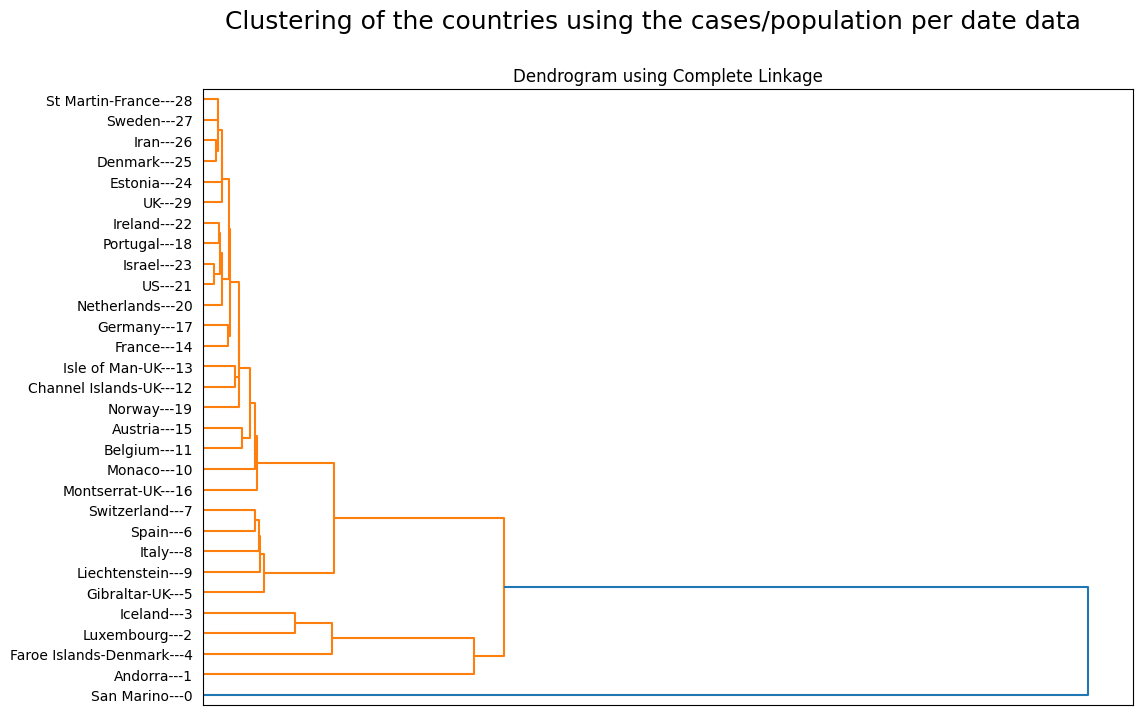

In [22]:
fig, axes = plt.subplots(figsize=(12, 8))

plot_hierarchy(data_2date_trunc, ax=axes)

axes.set_title('Dendrogram using Complete Linkage')
fig.suptitle('Clustering of the countries using the cases/population per date data', fontsize=18)

plt.savefig('../figures/Clustering2')

### Clustering cases per population per land area on date data

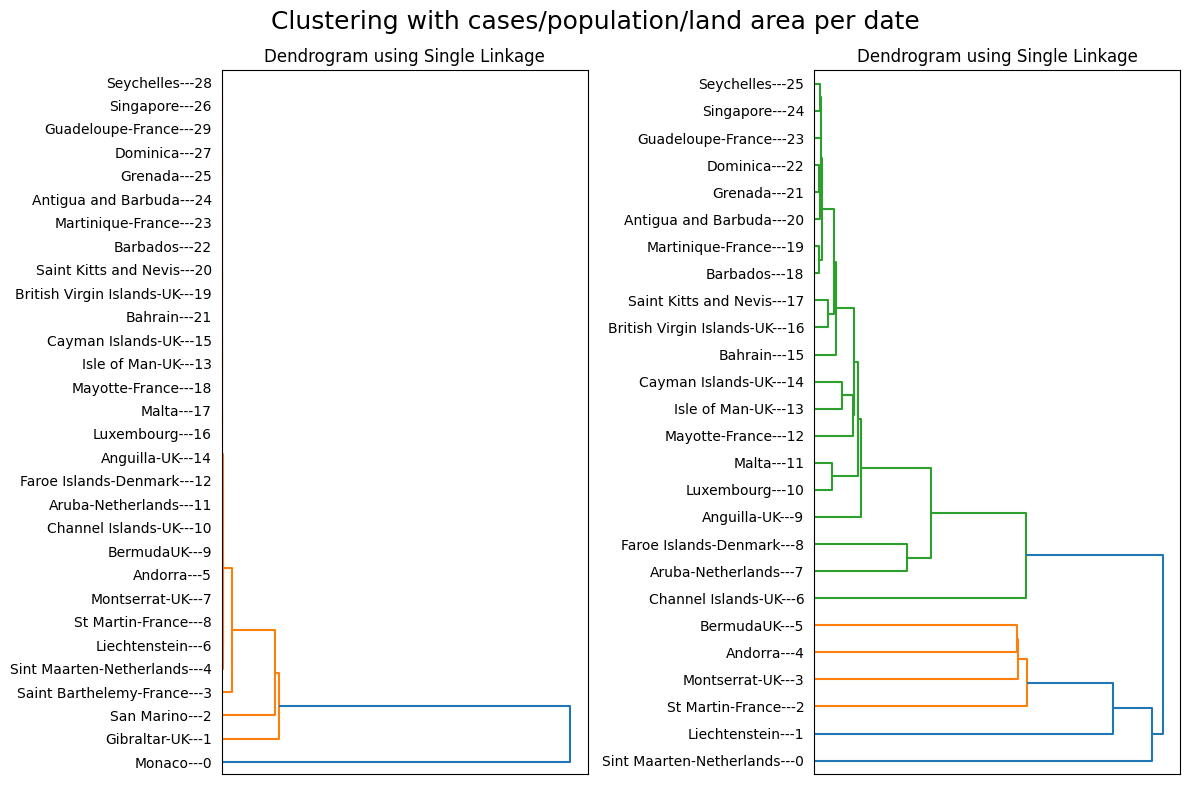

In [23]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2)

dend5, linkage_matrix5 = plot_hierarchy(data_5date_trunc, ax=axes[0])
plot_hierarchy(data_5date_trunc.iloc[:, dend5['leaves'][4:]], ax=axes[1])

fig.suptitle('Clustering with cases/population/land area per date', fontsize=18)
axes[0].set_title('Dendrogram using Single Linkage')
axes[1].set_title('Dendrogram using Single Linkage')

fig.tight_layout()

plt.savefig('../figures/Clustering5')

# World map

In [24]:
num_clusters = 6
method = 'complete'
metric = 'euclidean'
measure = 'Day'

if measure == 'Day':
    data_world = data_1day_trunc[:44].T.copy() 
else: 
    data_world = data_1date_trunc[:44].T.copy()  
columns = data_1day.columns & data_1date.columns

In [25]:
matrix = linkage(data_world, method=method, metric=metric)
cluster_assignment = cut_tree(matrix, n_clusters=num_clusters) + 1
clusters = pd.DataFrame(cluster_assignment, index=data_world.index)
temp = pd.DataFrame([0] * len(columns), index=columns, columns=['clusters'])
temp.loc[clusters.index] = clusters 
clusters = temp.copy()

In [26]:
codes = []
for country in clusters.index:
    try:
        codes.append(countrynames.to_code_3(country))
    except:
        try: 
            codes.append(pycountry.countries.get(name=country).alpha_3)
        except: 
            codes.append(country)
codes = pd.DataFrame(codes, index=clusters.index, columns=['CODE'])
data_world_clusters = clusters.join(codes)

In [27]:
geolocator = Nominatim(user_agent='covid_data')
def geolocate(country):
    try:
        loc = geolocator.geocode(country)
        return (loc.latitude, loc.longitude)
    except:
        return np.nan

In [28]:
location_list = [geolocate(country) for country in codes.iloc[:, 0]]
location_data = pd.DataFrame(location_list, index=codes.index, columns=['latitude', 'longitude'])
data_world_location = data_world_clusters.copy().join(location_data) 

In [29]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns = ['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
world_geoframe = pd.merge(world, data_world_location, on='CODE')

## Visualise clustered world map 

In [30]:
title = f'Cluster 30 countries into {num_clusters} subclusters'

chart = alt.Chart(world_geoframe, title=title).mark_geoshape().encode(
    color='clusters:N'
).project(
    'equirectangular'
).properties(
    width=800,
    height=400
)

chart.save('../figures/world_map.html')
chart

alt.Chart(...)

# Output files

In [31]:
data_1date_trunc.to_csv('../results/data_1date_trunc.csv')
data_2date_trunc.to_csv('../results/data_2date_trunc.csv')
data_5date_trunc.to_csv('../results/data_5date_trunc.csv')
data_1day_trunc.to_csv('../results/data_1day_trunc.csv')
data_2day_trunc.to_csv('../results/data_2day_trunc.csv')
data_5day_trunc.to_csv('../results/data_5day_trunc.csv')

data_1date_low.to_csv('../results/data_1date_low.csv')
data_2date_low.to_csv('../results/data_2date_low.csv')
data_5date_low.to_csv('../results/data_5date_low.csv')
data_1day_low.to_csv('../results/data_1day_low.csv')
data_2day_low.to_csv('../results/data_2day_low.csv')
data_5day_low.to_csv('../results/data_5day_low.csv') 

linkage_matrix1.to_csv('../results/linkage_matrix1.csv')
linkage_matrix5.to_csv('../results/linkage_matrix5.csv')

world_geoframe.to_csv('../results/world_geoframe.csv')